In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import pystan
%config InlineBackend.figure_format = 'retina'

In [2]:
full_df = pd.read_csv('data.csv')

In [3]:
# Calculate serve points won
loser_spw_won = full_df['winner_return_points_total'] - full_df['winner_return_points_won']
loser_sp_total = full_df['winner_return_points_total']
losers = full_df['loser']

winner_spw_won = full_df['loser_return_points_total'] - full_df['loser_return_points_won']
winner_spw_total = full_df['loser_return_points_total']
winners = full_df['winner']

In [4]:
winner_frame = pd.DataFrame({'server': winners, 
                             'returner': losers, 
                             'sp_won': winner_spw_won, 
                             'sp_total': winner_spw_total})

loser_frame = pd.DataFrame({'server': losers, 
                            'returner': winners, 
                            'sp_won': loser_spw_won, 
                            'sp_total': loser_sp_total})

combined = pd.concat([winner_frame, loser_frame])

# Drop the index
combined = combined.reset_index(drop=True)

In [5]:
combined.head()

,returner,server,sp_total,sp_won
0,Benjamin Mitchell,Tobias Kamke,59.0,42.0
1,Steve Johnson,Viktor Troicki,56.0,41.0
2,Gilles Simon,Grigor Dimitrov,81.0,54.0
3,Sam Groth,Hyeon Chung,73.0,49.0
4,John-Patrick Smith,Denis Kudla,73.0,55.0


In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

all_players = combined['server'].tolist() + combined['returner'].tolist()

encoder.fit(all_players)

server_ids = encoder.transform(combined['server'].values)
returner_ids = encoder.transform(combined['returner'].values)

In [7]:
# Basic spw model

model = """
data {
    int<lower=0> num_matches;
    int<lower=0> num_players;
    
    int s_id[num_matches]; // server ids
    int r_id[num_matches]; // returner ids
    
    int spw[num_matches]; // serve points won
    int spt[num_matches]; // serve points total
}
parameters {
    vector[num_players] s; // serving ability
    vector[num_players] r; // returning ability
    
    real<lower=0> sigma_s; // group-level variance for s
    real<lower=0> sigma_r; // group-level variance for r
    real theta_0; // intercept
}
model {
    // priors
    sigma_s ~ normal(0, 1);
    sigma_r ~ normal(0, 1);
    theta_0 ~ normal(0, 1);
    
    s ~ normal(0, sigma_s);
    r ~ normal(0, sigma_r);
    
    // Likelihood
    spw ~ binomial_logit(spt, s[s_id] - r[r_id] + theta_0);
}
"""

stan_model = pystan.StanModel(model_code=model)

In [8]:
stan_data = {'num_matches': combined.shape[0],
             'num_players': len(encoder.classes_),
             's_id': server_ids + 1,
             'r_id': returner_ids + 1,
             'spw': combined['sp_won'].values.astype(int),
             'spt': combined['sp_total'].values.astype(int)}

fit = stan_model.sampling(data=stan_data)

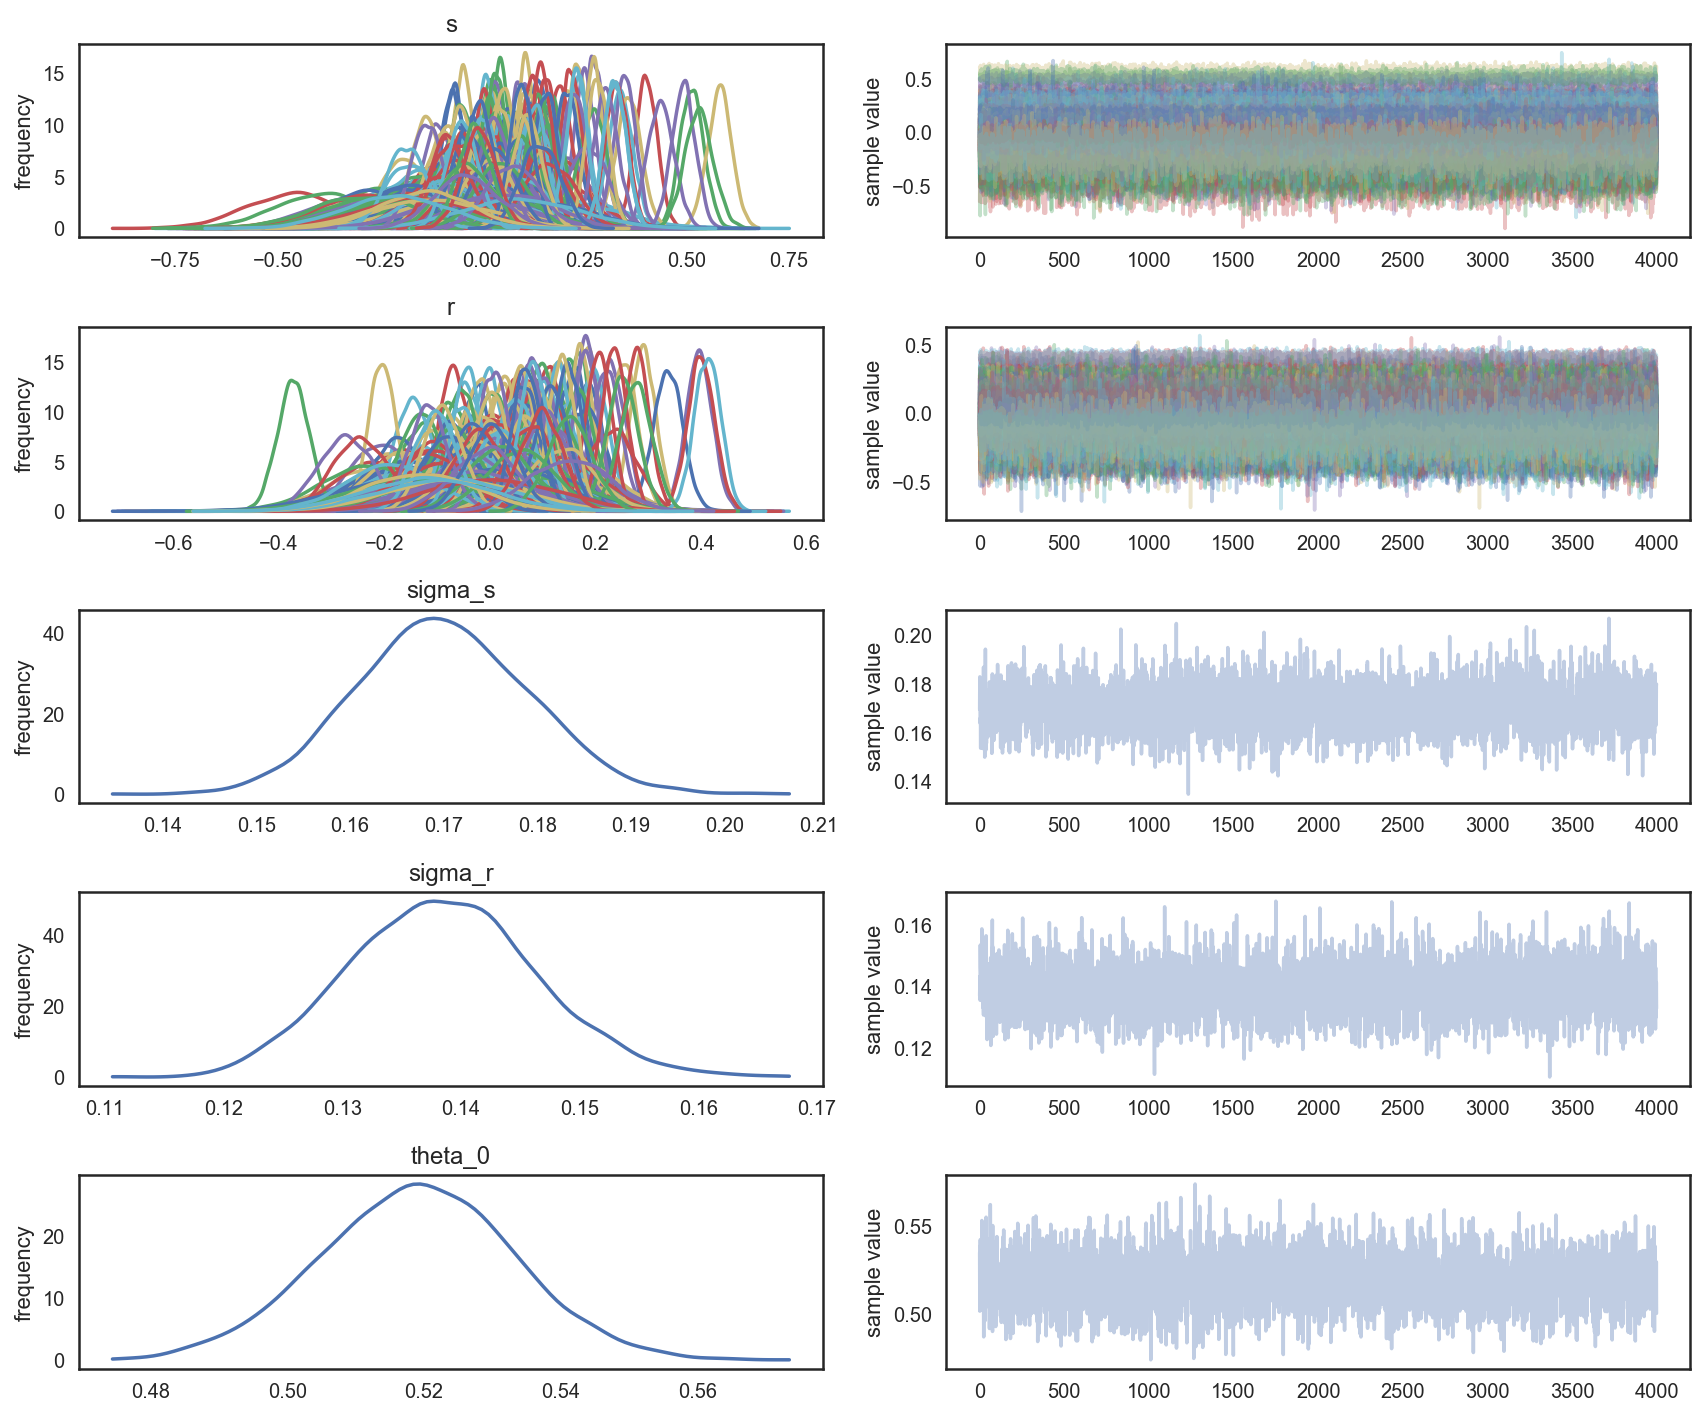

In [9]:
sns.set_style('white')
f = fit.plot()
f.set_size_inches(12, 10)
f.tight_layout()

In [10]:
results = fit.extract()

In [11]:
all_players = encoder.inverse_transform(range(len(encoder.classes_)))

In [12]:
# Top servers
s_means = pd.Series(results['s'].mean(axis=0), index=all_players)
s_means.sort_values(ascending=False).iloc[:10]

John Isner            0.581607
Roger Federer         0.530850
Ivo Karlovic          0.513628
Milos Raonic          0.493195
Nick Kyrgios          0.437548
Gilles Muller         0.401638
Kevin Anderson        0.358610
Marin Cilic           0.349231
Jo-Wilfried Tsonga    0.338966
Novak Djokovic        0.329389
dtype: float64

In [13]:
# Top returners
r_means = pd.Series(results['r'].mean(axis=0), index=all_players)
r_means.sort_values(ascending=False).iloc[:10]

Rafael Nadal                   0.413007
Novak Djokovic                 0.401073
Andy Murray                    0.397573
Diego Sebastian Schwartzman    0.338382
David Goffin                   0.290786
Kei Nishikori                  0.278121
Roger Federer                  0.276791
Gael Monfils                   0.254517
Richard Gasquet                0.251712
Roberto Bautista Agut          0.236473
dtype: float64

In [14]:
# Top serve + return
(s_means + r_means).sort_values(ascending=False).head(10)

Roger Federer         0.807641
Rafael Nadal          0.738298
Novak Djokovic        0.730462
Andy Murray           0.648690
Milos Raonic          0.575267
Nick Kyrgios          0.538088
Marin Cilic           0.532342
Kei Nishikori         0.496383
Gael Monfils          0.470557
Jo-Wilfried Tsonga    0.468051
dtype: float64

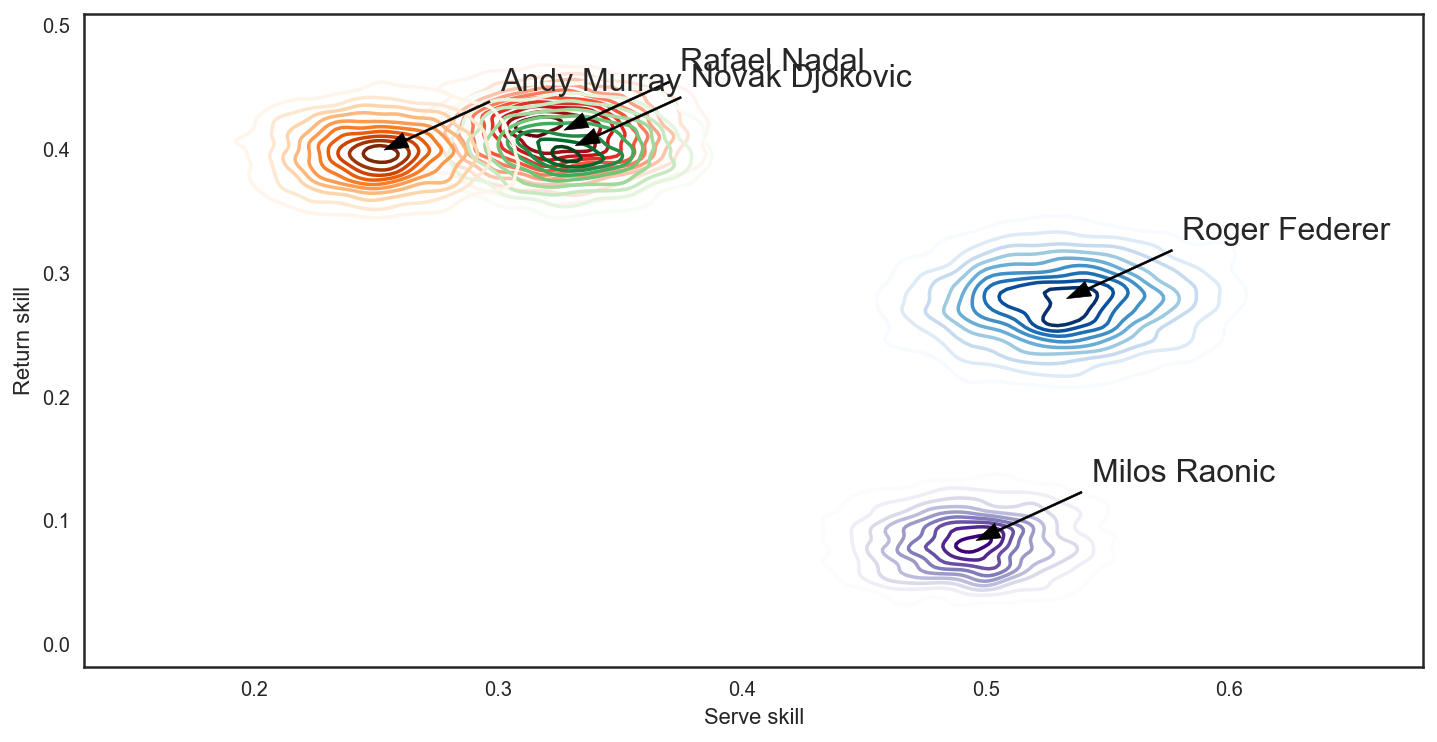

In [15]:
s_samples = pd.DataFrame(results['s'], columns=all_players)
r_samples = pd.DataFrame(results['r'], columns=all_players)

top_5 = (s_samples + r_samples).mean(axis=0).sort_values(ascending=False).iloc[:5].index

s_top_5 = s_samples[top_5]
r_top_5 = r_samples[top_5]

cmaps = ['Blues', 'Reds', 'Greens', 'Oranges', 'Purples']

f, ax = plt.subplots(1, 1)

for cur_player, cur_colour in zip(top_5, cmaps):
    sns.kdeplot(s_top_5[cur_player], r_top_5[cur_player], cmap=cur_colour, ax=ax)
    cur_x = np.median(s_top_5[cur_player])
    cur_y = np.median(r_top_5[cur_player])
    ax.annotate(cur_player, xy=(cur_x, cur_y), xytext=(cur_x + 0.05, cur_y + 0.05),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8), fontsize=16
            )

plt.xlabel('Serve skill')
plt.ylabel('Return skill')

plt.gcf().set_size_inches(12, 6)

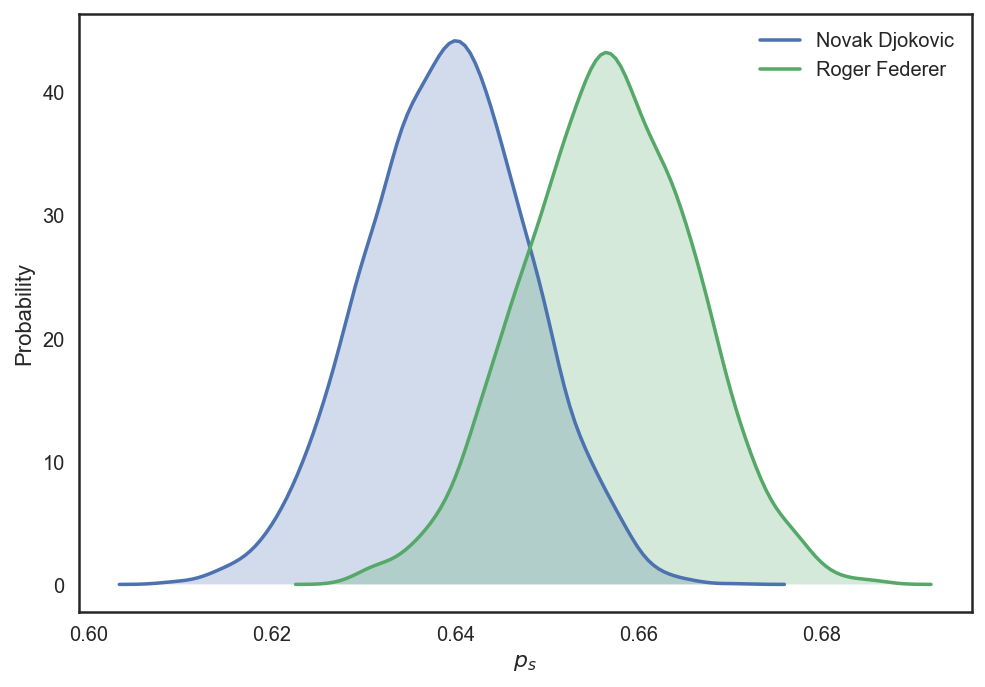

In [16]:
from scipy.special import expit

p1 = 'Novak Djokovic'
p2 = 'Roger Federer'

p1_probs = expit(s_samples[p1] - r_samples[p2] + fit['theta_0'])
p2_probs = expit(s_samples[p2] - r_samples[p1] + fit['theta_0'])

sns.kdeplot(p1_probs, label=p1, shade=True)
sns.kdeplot(p2_probs, label=p2, shade=True)

plt.xlabel('$p_s$')
plt.ylabel('Probability')